[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/saschwarz/yolov8-bbox-segment-anything/blob/main/Yolov8_bbox_segment_anything.ipynb)


# Using MetaSeg to Generate Yolov8 Segmentation Annotations from Existing Bounding Boxes

## Install/Use MetaSeg Package

https://github.com/kadirnar/segment-anything-video

In [1]:
!nvidia-smi

Fri Apr 14 11:12:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install metaseg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 9.5 MB/s eta 0:00:00
  Created wheel for metaseg: filename=metaseg-0.6.1-py3-none-any.whl size=44772 sha256=b51a3da20036b3baf22222daddfe34a6d38cc43bfc6a6d92d5396928dc91ea61
  Stored in directory: /root/.cache/pip/wheels/b1/0c/bd/5e8d8f9aa755ac2f82e75b9391db0d403f760a4654b19c8b6c
Successfully built metase

In [3]:
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

## Get test dataset

In [4]:
!git clone https://github.com/saschwarz/yolov8-bbox-segment-anything.git

Cloning into 'yolov8-bbox-segment-anything'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 59 (delta 11), reused 50 (delta 7), pack-reused 0
Unpacking objects: 100% (59/59), 1.59 MiB | 3.08 MiB/s, done.


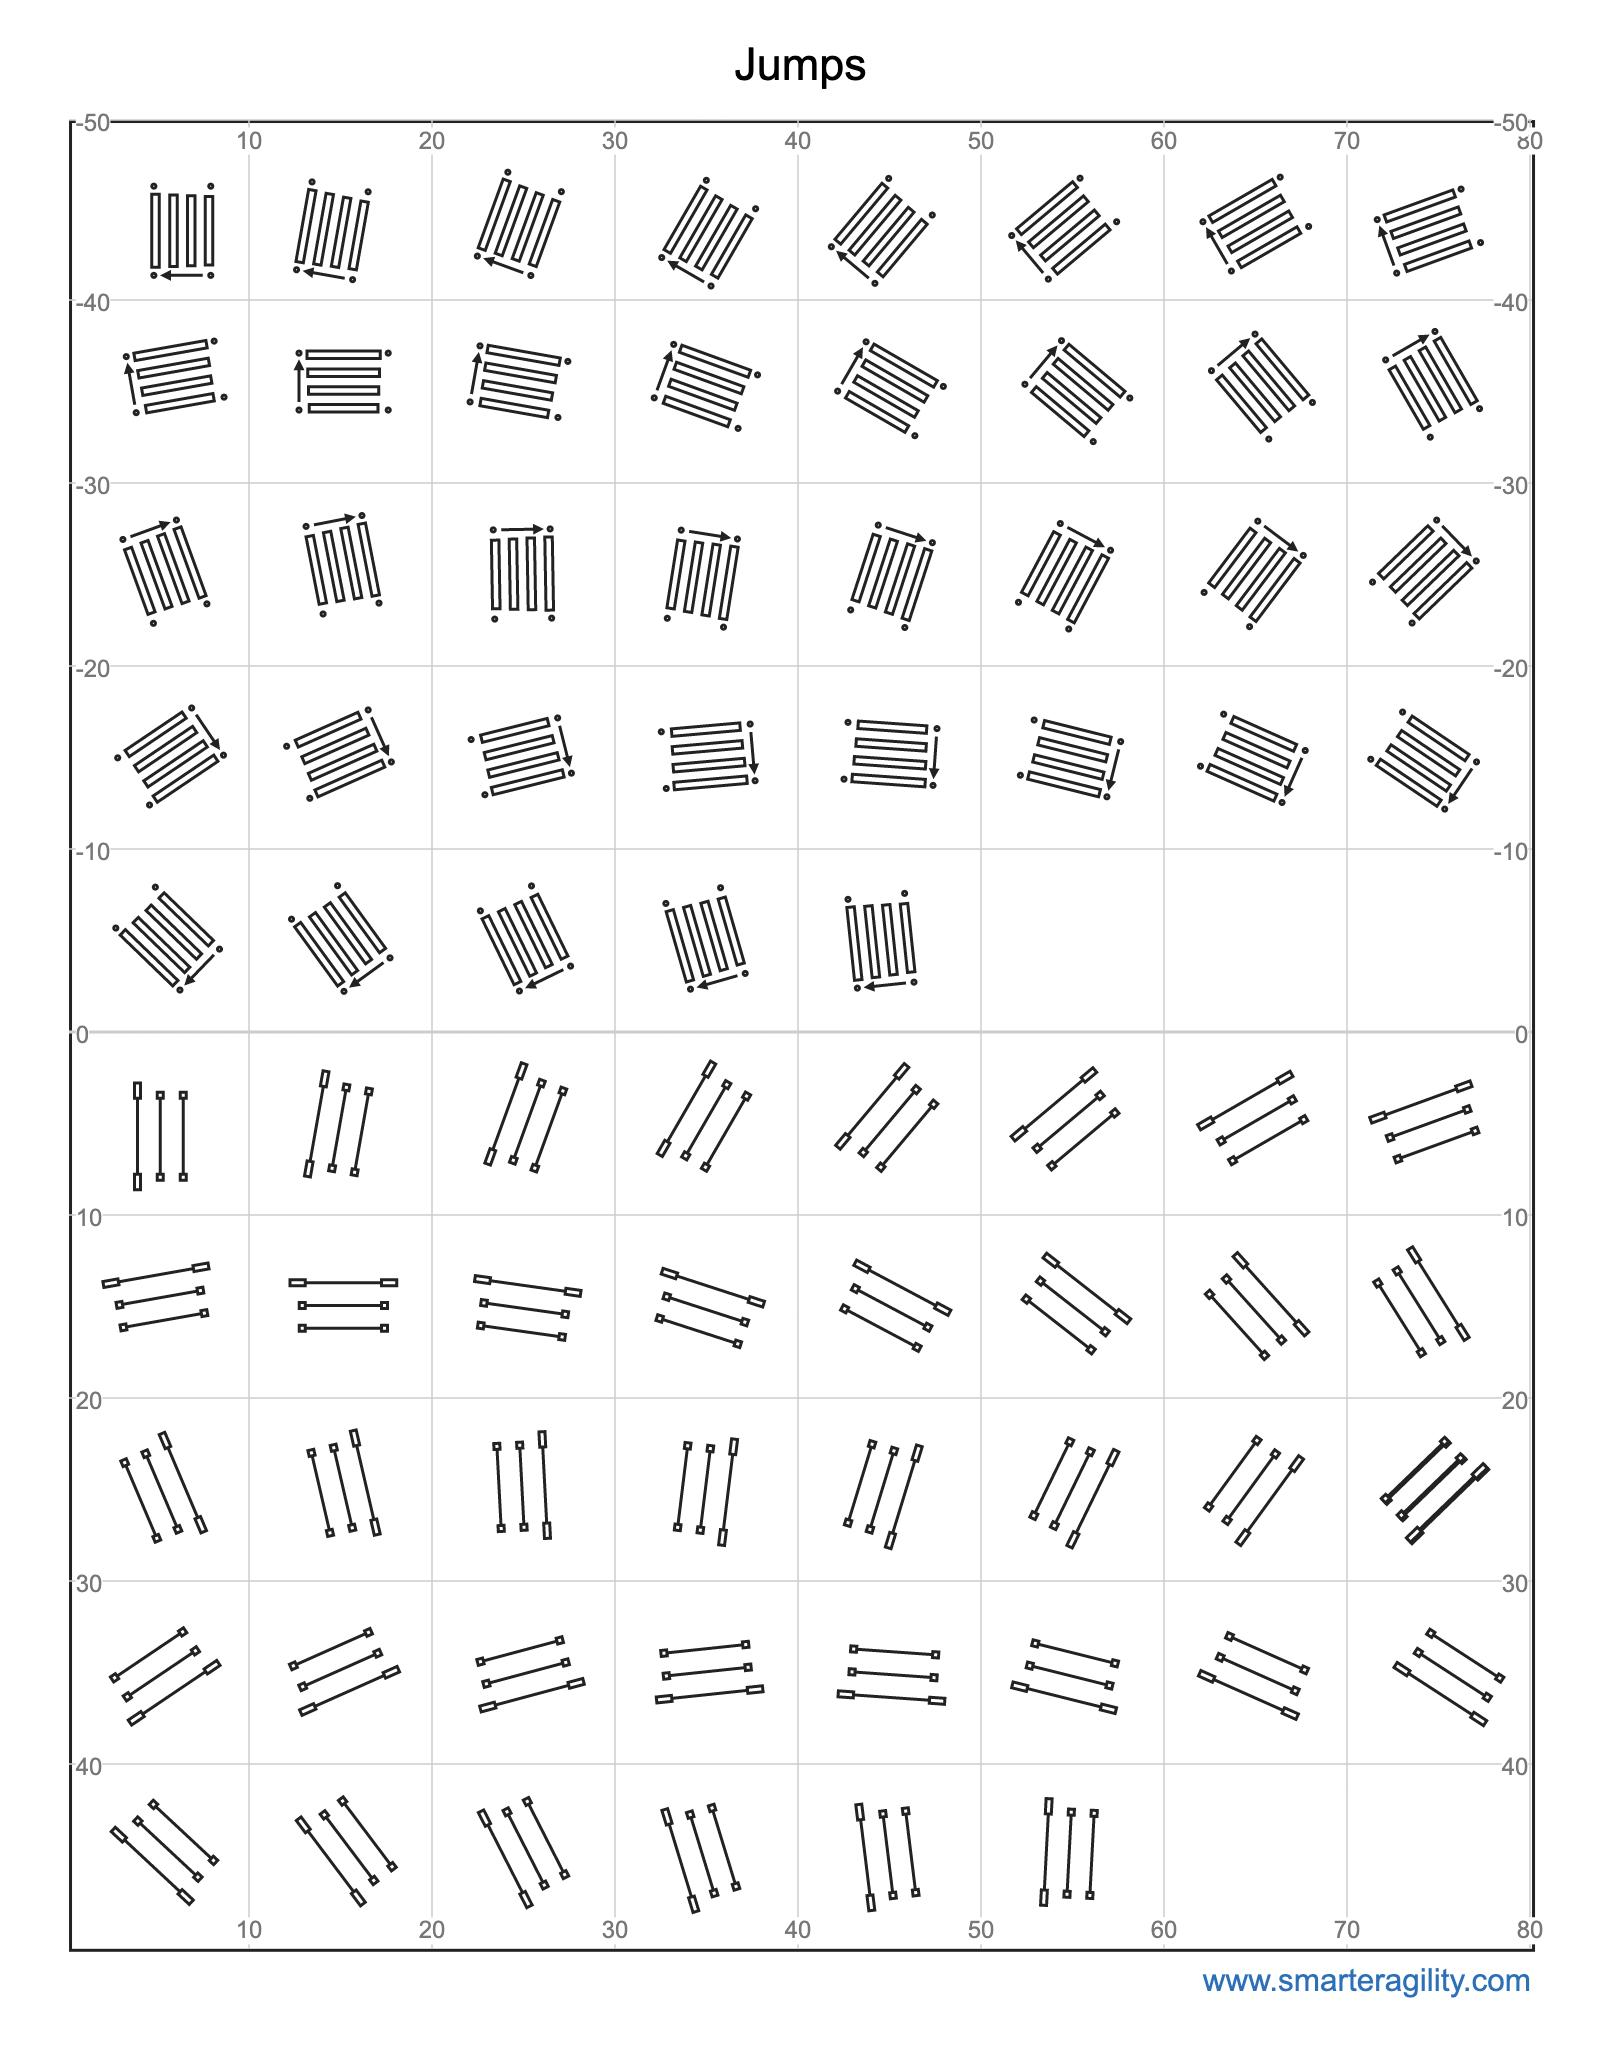

In [5]:
from IPython.display import Image
Image("/content/yolov8-bbox-segment-anything/dataset/test/images/jumps_277237-1-_png.rf.042f0cedb04d03ff80f23bd7409454ad.jpg")

## Use MetaSeg on One Image

vit_l model already exists as 'vit_l.pth'. Skipping download.


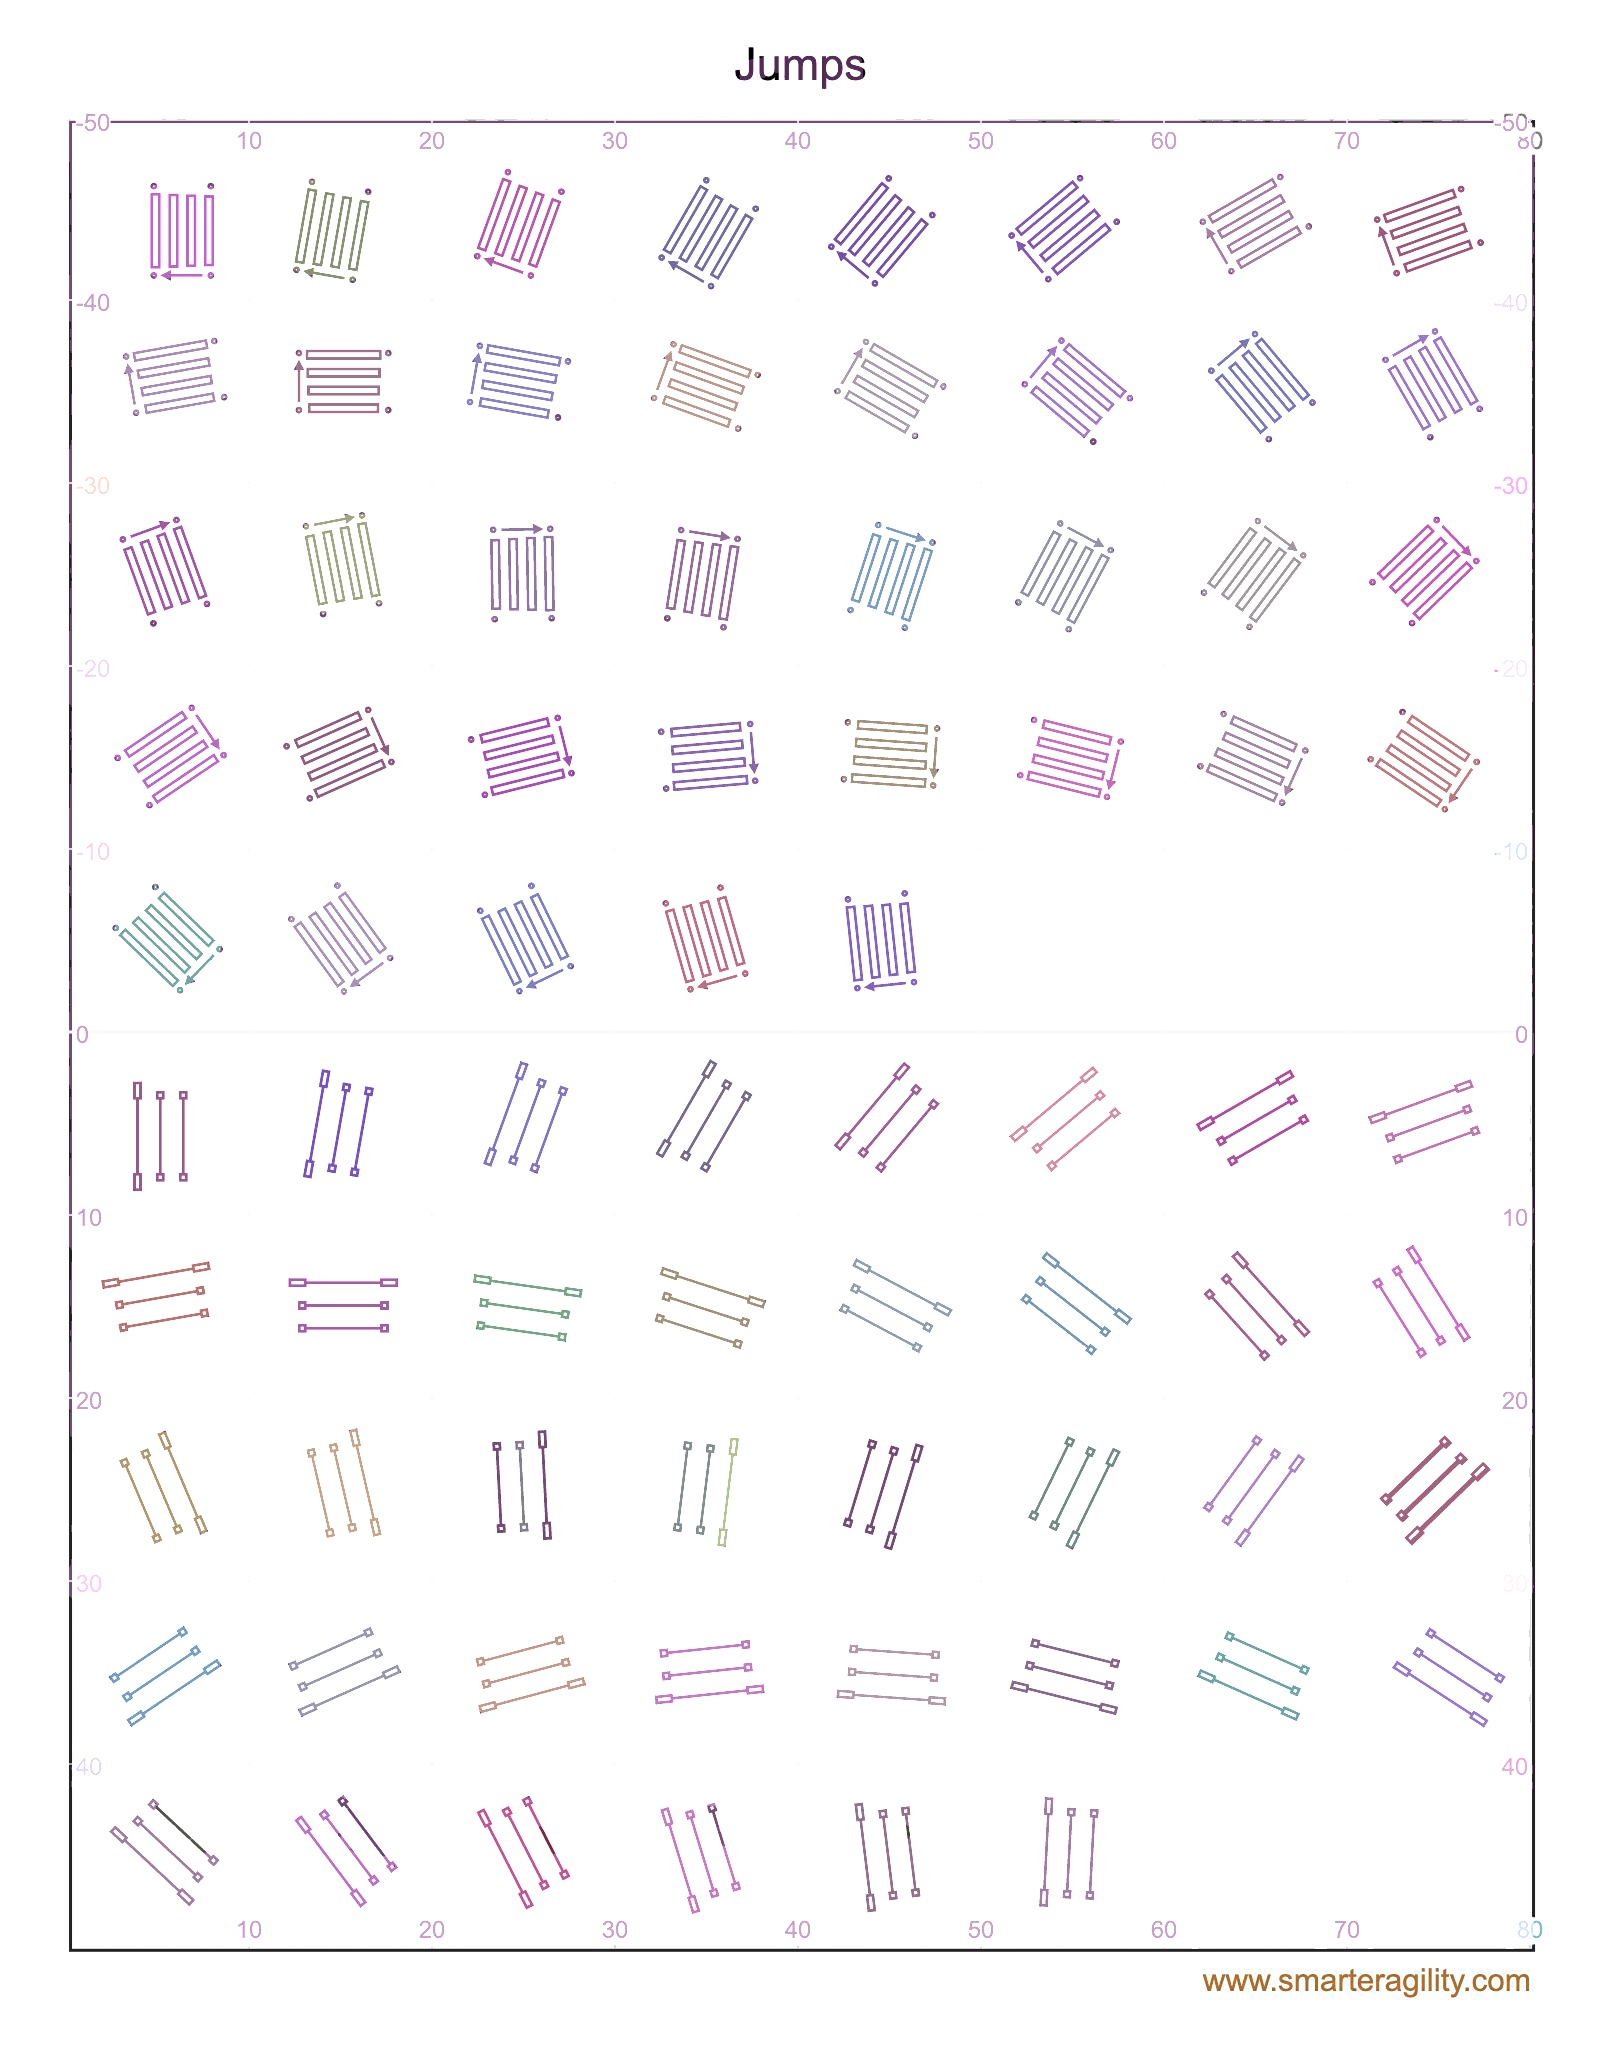

In [11]:
results = codeautoseg_image = SegAutoMaskPredictor().image_predict(
    source="/content/yolov8-bbox-segment-anything/dataset/test/images/jumps_277237-1-_png.rf.042f0cedb04d03ff80f23bd7409454ad.jpg",
    model_type="vit_l",
    points_per_side=32, 
    points_per_batch=64,
    min_area=0,
    output_path="output.jpg",
    save=True
)
# print(results)
Image("output.jpg")

## Apply MetaSeg to Generate Segmentation Annotations to Using Existing Bounding Boxes

In [6]:
!pip install globox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from globox import AnnotationSet, BoundingBox
import json
from pathlib import Path
import cv2
import torch

ROOT = Path("/content/yolov8-bbox-segment-anything/dataset/train/")
IMAGE_ROOT = ROOT / "images"
LABEL_ROOT = ROOT / "labels"

gts = AnnotationSet.from_yolo_v7(    
    folder=LABEL_ROOT,
    image_folder=IMAGE_ROOT)

# gts.show_stats()

for filename, annotation in gts.items():
  print(filename, annotation.image_width, annotation.image_height, len(annotation.boxes))
  # for idx, bbox in enumerate(annotation.boxes[10:]):
  full_path = str(IMAGE_ROOT / filename)
  #   image = cv2.imread(full_path)
  #   copy = image.copy()
  #   print(bbox)
  #   print(idx, full_path)
  #   print(bbox.xmin, bbox.ymin, bbox.xmax, bbox.ymax)
  #   # cv2.rectangle(copy, 
  #   #               [int(bbox.xmin), int(bbox.ymin)], 
  #   #               [int(bbox.xmax), int(bbox.ymax)], 
  #   #               (0, 0, 255), 2)
  idx = 0
  output = f"{filename}-{idx}.png"
  #   # cv2.imwrite(output, copy)
  #   # Image(output)    
  input_boxes = [[int(b.xmin), int(b.ymin), int(b.xmax), int(b.ymax)] for b in annotation.boxes[:1]]
  print(input_boxes)
  try:
    result = SegManualMaskPredictor().image_predict(
        source=full_path,
        model_type="vit_l",
        input_point=None,
        input_label=None,
        input_box=input_boxes[0],
        multimask_output=False,
        random_color=True,
        save=True,
        output_path="output.png"
    )
    print(type(result))
    print(list(result))
    Image('output.png')
  except Exception as e:
    print(e)


jumps-3_277225_png.rf.a788d4e02595959f5f497670dab7d536.jpg 1599 2046 73
[[144, 150, 191, 287]]
vit_l model already exists as 'vit_l.pth'. Skipping download.
<class 'numpy.ndarray'>
[array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])]
